# Run the LSST pipeline on VISTA Y and Ks in SXDS with the gen2 Butler.

We will need to ingest all the stacks on a given tile area. Then make the coadds to form the tile. Then detect and measure sources on that tile.

This is done with the 'gen2' butler. While the pipeline tasks are independent of the Butler they are executed using different commands with gen2 or gen3 because the Butler manages the input and output of data to and from the tasks. We will go on to repeat the process with the gen3 Butler.

In [415]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import os
import yaml
import glob
import numpy as np

import matplotlib.pyplot as plt

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

The first stage is to ingest the images. The full commands are 

```Shell
export vista_raw=/path/to/vista/data/folder
mkdir data
echo 'lsst.obs.vista.VistaMapper'>data/_mapper
ingestImages.py data $vista_raw*_st.fit --mode=link --config clobber=True
mkdir -p data/ref_cats
ln -s /path/to/panstarrs/PanSTARRS/ps1_pv3_3pi_20170110_GmagLT19 data/ref_cats/ps1_pv3_3pi_20170110

```
Then we run through the photometry pipeline


```Shell
processCcd.py data --rerun processCcdOutputs --id --clobber-config
#Then we make the skymap discrete makes small section around images with zero indexing
#makeDiscreteSkyMap.py data --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"
makeSkyMap.py data --rerun processCcdOutputs:coadd #config in obs_vista
#Then we warp the images to the skymap
makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=8523^8524 --config doApplyExternalPhotoCalib=False doApplyExternalSkyWcs=False doApplySkyCorr=False
makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract=8523^8524 --config doApplyExternalPhotoCalib=False doApplyExternalSkyWcs=False doApplySkyCorr=False
#Then we assemble the coadds
assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract=8523 patch==0,2^0,3^0,4^0,5^0,6^0,7^0,8
#Lets just run the one tract for now
#assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=8524 patch=2,2^2,3^2,4^2,5^2,6^2,7^2,8^3,2^3,3^3,4^3,5^3,6^3,7^3,8^4,2^4,3^4,4^4,5^4,6^4,7^4,8^5,2^5,3^5,4^5,5^5,6^5,7^5,8^6,2^6,3^6,4^6,5^6,6^6,7^6,8^7,2^7,3^7,4^7,5^7,6^7,7^7,8^8,2^8,3^8,4^8,5^8,6^8,7^8,8
#assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Ks --id filter=VISTA-Ks tract=8524 patch=2,2^2,3^2,4^2,5^2,6^2,7^2,8^3,2^3,3^3,4^3,5^3,6^3,7^3,8^4,2^4,3^4,4^4,5^4,6^4,7^4,8^5,2^5,3^5,4^5,5^5,6^5,7^5,8^6,2^6,3^6,4^6,5^6,6^6,7^6,8^7,2^7,3^7,4^7,5^7,6^7,7^7,8^8,2^8,3^8,4^8,5^8,6^8,7^8,8
#Then detect sources 
detectCoaddSources.py data --rerun coadd:coaddPhot --id filter=VISTA-Y tract=8523 patch==0,2^0,3^0,4^0,5^0,6^0,7^0,8
detectCoaddSources.py data --rerun coadd:coaddPhot --id filter=VISTA-Ks tract=8523 patch==0,2^0,3^0,4^0,5^0,6^0,7^0,8
#Merge any detection catalogues
mergeCoaddDetections.py data --rerun coaddPhot --id filter=VISTA-Y^VISTA-Ks tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
#deblend without tract patch it hangs running over sky
deblendCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Y tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
deblendCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Ks tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
# measure
measureCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Y tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
measureCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Ks tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8

mergeCoaddMeasurements.py data --rerun coaddPhot --id filter=VISTA-Y^VISTA-Ks tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8

forcedPhotCoadd.py data --rerun coaddPhot:coaddForcedPhot --id filter=VISTA-Y tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
forcedPhotCoadd.py data --rerun coaddForcedPhot --id filter=VISTA-Ks tract=8523 patch=0,2^0,3^0,4^0,5^0,6^0,7^0,8
```

The equivalent of all the above commands using the Python api is (every command line task has an associated python task api but not the reverse).

<pre><code>
ingestImages
processCcd
</code></pre>


## 1. Example area

In [../dmu1/2_Survey_comparisons.ipynb](../dmu1/2_Survey_comparisons.ipynb) we found some test VISTA images in the SXDS field (where we have HSC DUD imaging). 

![](./figs/1_sxds_tracts.png)

I simply took the VISTA tiles closest to radec 35., -5. We will see later these tiles are in tracts 8523 and 8524.

In [304]:
def data_loc(base=None):
    """Return data locations depending on machine used
    
    Returns
    -------
    str
        Full path to data repository
    """
    if base == None:
        cwd = os.getcwd()
        base = cwd.split('lsst-ir-fusion')[0] + 'lsst-ir-fusion/'
    
    
    overide = base + 'dmu0/data_local.yml'
    standard = base + 'dmu0/data_local_template.yml'
    print(overide)
    if os.path.exists(overide):
        data_loc = yaml.load(open(overide, 'rb'))
    else:
        data_loc = yaml.load(open(standard, 'rb'))
        for k, v in data_loc.items():
            #print(k,v)
            data_loc[k] = v.replace('BASE/', base)
    return data_loc
data_loc = data_loc()

/Users/rs548/GitHub/lsst-ir-fusion/dmu0/data_local.yml


/Users/rs548/GitHub/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [305]:
data_loc

{'vista': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/',
 'video': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/',
 'viking': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIKING/data/',
 'vhs': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VHS/data/',
 'hsc': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_HSC/data/',
 'panstarrs': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/',
 'gaia': '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_GAIA/data/'}

In [306]:

vista_test = glob.glob(data_loc['vista'] + "**/*st.fit", recursive=True)

In [307]:
vista_test

['/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00102_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00235_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00207_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00186_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00151_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00116_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00179_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00130_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/20121122/v20121122_00165_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/dmu0/dmu0_VISTA/dmu0_VIDEO/data/2012

In [39]:

import lsst.daf.persistence
DATA_DIR = "/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data/"
butler = lsst.daf.persistence.Butler(DATA_DIR)

In [42]:
butler

Butler(datasetTypeAliasDict={}, repos=RepoDataContainer(_inputs=[RepoData(id=5086610128,repoArgs=RepositoryArgs(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test', cfgRoot=None, mapper=<class 'lsst.obs.vista.vistaMapper.VistaMapper'>, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test', mapper=<class 'lsst.obs.vista.vistaMapper.VistaMapper'>, mapperArgs={}, parents=[], policy=None),cfgOrigin=existing,cfgRoot=/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test,repo=<lsst.daf.persistence.repository.Repository object at 0x12f322790>,parentRepoDatas=[],isV1Repository=True,role=output,parentRegistry=None)], 
_outputs=[RepoData(id=5086610128,repoArgs=RepositoryArgs(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_test', cfgRoot=None, mapper=<class 'lsst.obs.vista.vistaMapper.VistaMapper'>, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/Users/rs548/GitHub/lsst-ir-fusion/dmu4/data_tes

In [270]:
def cutout_scale(im, num_min = 2.0, num_max = 5.0):
    """
    Takes an image array and returns the vmin and vmax required to scale the image 
    between median + 5 * sigma MAD and median - 2 * sigma MAD
    """

    import numpy as np
    import astropy.stats as apys

    data = im.flatten()   #Return a copy of the array collapsed into one dimension

    try:
        med = np.median(data[np.isnan(data)!=1])
        sigma_MAD = apys.mad_std(data[np.isnan(data)!=1])
    except IndexError:
        med = 0.0
        sigma_MAD = 0.0
    vmax = med + num_max * sigma_MAD
    vmin = med - num_min * sigma_MAD

    return vmin, vmax


In [263]:
def plot_fits(im_hdu):
    wcs = WCS(im_hdu.header)
    #wcs = WCS(data_loc + 'private/VISTA/VIDEO/20180911/v20180911_00266_st.fit')
    vmin, vmax = cutout_scale(im_hdu.data)
    plt.subplot(projection=wcs)
    plt.imshow(im_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.grid(color='white', ls='solid')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    


NameError: name 'hsc' is not defined

In [319]:
y_test = vista_test[0]
ks_test = vista_test[24]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


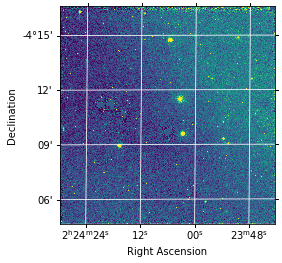

In [320]:
plot_fits(fits.open(y_test)[1]) #The first ccd in the multi extension fits file

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


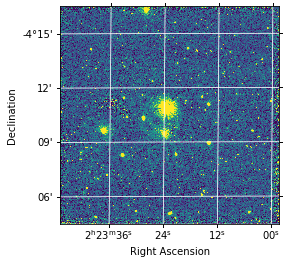

In [321]:
plot_fits(fits.open(ks_test)[1])

In [322]:
#We will need to translate the key header values for the primary unit and each ccd
fits.open(y_test)[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ESO     '                    / European Southern Observatory         
DATE    = '2012-11-23T01:48:04'         / Date this file was written            
TELESCOP= 'VISTA   '                    / ESO Telescope Name                    
INSTRUME= 'VIRCAM  '                    / Instrument used.                      
OBJECT  = 'No name '           / Original target.                               
RA      =            35.616442          / 02:22:27.9 RA (J2000) pointing (deg)  
DEC     =             -4.723

In [324]:
#The way the lsst stack reads headers is a little different to astropy
from lsst.afw.fits import readMetadata
md = readMetadata(y_test, 12)
md.toDict()

{'XTENSION': 'BINTABLE',
 'BITPIX': 8,
 'NAXIS': 2,
 'NAXIS1': 8,
 'NAXIS2': 2127,
 'PCOUNT': 5248491,
 'GCOUNT': 1,
 'TFIELDS': 1,
 'TTYPE1': 'COMPRESSED_DATA',
 'TFORM1': '1PB(2922)',
 'ZIMAGE': True,
 'ZBITPIX': 32,
 'ZNAXIS': 2,
 'ZNAXIS1': 2106,
 'ZNAXIS2': 2127,
 'ZTILE1': 2106,
 'ZTILE2': 1,
 'ZCMPTYPE': 'RICE_1',
 'ZNAME1': 'BLOCKSIZE',
 'ZVAL1': 32,
 'ZNAME2': 'BYTEPIX',
 'ZVAL2': 4,
 'EXTNAME': 'DET1.CHIP12',
 'ORIGIN': 'ESO',
 'DATE': '2012-11-23T01:49:20.8069',
 'EXPTIME': 10.0,
 'MJD-OBS': 56254.0750632,
 'DATE-OBS': '2012-11-23T01:48:05.4411',
 'CTYPE1': 'RA---ZPN',
 'CTYPE2': 'DEC--ZPN',
 'CRVAL1': 35.6164759207873,
 'CRVAL2': -4.72388826660655,
 'CRPIX1': -3363.911,
 'CRPIX2': -926.1008,
 'ORIGFILE': 'VIRCAM_IMG_OBS328_0045_DET12.fits',
 'CD1_1': -9.48509387172261e-05,
 'CD1_2': 1.43185934501151e-07,
 'CD2_1': -1.36712879937139e-07,
 'CD2_2': -9.48617996848186e-05,
 'ESO DET CHIP ID': 'ESO-Virgo46',
 'ESO DET CHIP LIVE': True,
 'ESO DET CHIP NAME': 'Virgo',
 'ESO DET CH

## 3. Viewing calibrated images

Checking we can display the result of the VISTA processCcd run which produced calexp exposures and source lists for what it thought was a single exposure (actually a stack we had given it).

These commands send the images to ds9 which needs to be open. 

In [325]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs='data/rerun/processCcdOutputs')

In [330]:
calexp = butler.get('calexp', dataId={'filter': 'VISTA-Ks', 'visit': 658653, 'ccd': 00})

In [331]:
import lsst.afw.display as afwDisplay

In [332]:
display = afwDisplay.getDisplay()

In [333]:
display.mtv(calexp)

In [334]:
display.setMaskTransparency(60)

In [335]:
display.scale("asinh", "zscale")

In [336]:
display.scale("asinh", -1, 30)

In [337]:
mask = calexp.getMask()
for maskName, maskBit in mask.getMaskPlaneDict().items():
    print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)))

BAD: red
CR: magenta
DETECTED: blue
DETECTED_NEGATIVE: cyan
EDGE: yellow
INTRP: green
NO_DATA: orange
SAT: green
SUSPECT: yellow
UNMASKEDNAN: None


In [339]:
src = butler.get('src', dataId={'filter': 'VISTA-Ks', 'visit': 658653, 'ccd': 00})

In [340]:
print(len(src))

2510


In [341]:
print(src.getSchema())

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psf_candidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Fiel

In [342]:
print(src.getSchema().getNames())

{'deblend_patchedTemplate', 'base_LocalBackground_flag', 'base_SdssCentroid_flag_noSecondDerivative', 'calib_psf_used', 'base_PsfFlux_flag_noGoodPixels', 'base_LocalWcs_CDMatrix_1_1', 'base_PsfFlux_apCorrErr', 'base_CircularApertureFlux_6_0_instFluxErr', 'base_CircularApertureFlux_9_0_instFluxErr', 'base_CircularApertureFlux_25_0_flag_apertureTruncated', 'base_CircularApertureFlux_35_0_instFlux', 'base_Variance_value', 'base_SdssShape_xyErr', 'base_SdssShape_instFlux_xy_Cov', 'base_CircularApertureFlux_25_0_instFlux', 'base_LocalBackground_flag_noPsf', 'base_SdssCentroid_x', 'base_SdssCentroid_flag', 'base_Blendedness_abs_child_instFlux', 'base_CircularApertureFlux_3_0_flag_apertureTruncated', 'base_SdssCentroid_flag_resetToPeak', 'deblend_masked', 'base_CircularApertureFlux_12_0_instFlux', 'coord_ra', 'base_Variance_flag', 'base_Blendedness_abs_child_yy', 'base_PsfFlux_area', 'base_PixelFlags_flag_offimage', 'base_SdssCentroid_flag_almostNoSecondDerivative', 'base_GaussianFlux_apCorrE

In [343]:
print(src.schema.find("calib_psf_used"))

(Key['Flag'](offset=32, bit=2), Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"))


In [344]:
print(src['base_PsfFlux_instFlux'])

[ 276.28892666  187.11358332  272.03204197 ...   90.27714175 1977.9832727
 1719.51627593]


In [345]:
with display.Buffering():
    for s in src:
        display.dot("o", s.getX(), s.getY(), size=10, ctype='orange')
        

In [346]:
display.erase()

In [347]:
with display.Buffering():
    for s in src[src['calib_psf_used']]:
        display.dot("x", s.getX(), s.getY(), size=10, ctype='red')

In [348]:
rejectedPsfSources = src[src['calib_psf_candidate'] &
                         (src['calib_psf_used'] == False)]
with display.Buffering():
    for s in rejectedPsfSources:
        display.dot("+", s.getX(), s.getY(), size=10, ctype='green')

## 4. Warping and Coadding

Remember from the beginning these are run as command line tasks

```Shell
#Make the sky map
makeDiscreteSkyMap.py data --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"
#Make the warps (for the first ccd we need a tract with 2*2 patches)
makeCoaddTempExp.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=0 patch=0,0^0,1^1,0^1,1     --config doApplyExternalPhotoCalib=False doApplyExternalSkyWcs=False doApplySkyCorr=False
#Coadd the warps
assembleCoadd.py data --rerun coadd --selectId filter=VISTA-Y --id filter=VISTA-Y tract=0 patch=0,0^0,1^1,0^1,1
```

In order to run these commands we need to know the tracts we wish to warp. If not the command will run over the whole sky and mainly produce empty images. We therefore need to use the lsst stack to get the relevant tracts/patches

In [371]:
#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

#Following taken from dmu1/2_Survey_comparisons.ipynb test choice
coord = SpherePoint(35.429025*degrees,-4.90853*degrees)
config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sm.findTract(coord)

TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431])

In [378]:
sm.findTract(coord).findPatch(coord)

PatchInfo(index=(5, 6), innerBBox=(minimum=(20000, 24000), maximum=(23999, 27999)), outerBBox=(minimum=(19900, 23900), maximum=(24099, 28099)))

In [376]:
sm.findTractPatchList(
    [
        SpherePoint(35.429025*degrees,-4.90853*degrees),
        SpherePoint(35.0*degrees,-5.*degrees)
    ]
)

[(TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431]),
  (PatchInfo(index=(5, 5), innerBBox=(minimum=(20000, 20000), maximum=(23999, 23999)), outerBBox=(minimum=(19900, 19900), maximum=(24099, 24099))),
   PatchInfo(index=(5, 6), innerBBox=(minimum=(20000, 24000), maximum=(23999, 27999)), outerBBox=(minimum=(19900, 23900), maximum=(24099, 28099))),
   PatchInfo(index=(6, 5), innerBBox=(minimum=(24000, 20000), maximum=(27999, 23999)), outerBBox=(minimum=(23900, 19900), maximum=(28099, 24099))),
   PatchInfo(index=(6, 6), innerBBox=(minimum=(24000, 24000), maximum=(27999, 27999)), outerBBox=(minimum=(23900, 23900), maximum=(28099, 28099))),
   PatchInfo(index=(7, 5), innerBBox=(minimum=(28000, 20000), maximum=(31999, 23999)), outerBBox=(minimum=(27900, 19900), maximum=(32099, 24099))),
   PatchInfo(index=(7, 6), innerBBox=(minimum=(28000, 24000), maximum=(31999, 27999)), outerBBox=(minimum=(27900, 23900), maximum=(32099, 28099))),
   PatchInfo(inde

### 4.1 PanSTARRS reference catalogues

We need photometric reference points for VISTA bands

z = panSTARRS and conversion?
Y = panSTARRS and conversion
J = 2MASS
H = 2MASS
Ks = 2MASS and conversion?

## 5. Detecting and measuring

```Shell
#Detecting sources I think we don't need to specify tracts and patches defaults to all - however will hang running over full sky tracts
detectCoaddSources.py data --rerun coadd:coaddPhot --id filter=VISTA-Y 
#Next redo this for same area in other band (TODO this will not run now)
#Merge multiband source detection catalogues
#mergeCoaddDetections.py data --rerun coaddPhot --id filter=VISTA-Y^VISTA-z
#Deblending only possible with multiple bands
#deblendCoaddSources.py data --rerun coaddPhot --id filter=VISTA-Y
```

In [ ]:
#Of the 7 or so patches sent to detection and measurement only one passed without error tract: 8523, patch: 0,7

## 6. Working with the Butler
Now we have run through the full gen2 HSC examples on VISTA lets use the gen2 Butler to investigate teh database and products

In [379]:
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs='data/rerun/coaddForcedPhot')


In [380]:
ySources = butler.get('deepCoadd_forced_src', {'filter': 'VISTA-Y', 'tract': 8523, 'patch': '0,7'})
ksSources = butler.get('deepCoadd_forced_src', {'filter': 'VISTA-Ks', 'tract': 8523, 'patch': '0,7'})

In [249]:
#gen2 Butler appears to need to be told about reruns
butler = dafPersist.Butler(inputs='data_test/rerun/processCcdOutputs')

In [382]:
#Units used in repo
ySources.getSchema().find('base_PsfFlux_instFlux').field.getUnits()


'count'

In [384]:
yCoaddPhotoCalib = butler.get('deepCoadd_calexp_photoCalib',  {'filter': 'VISTA-Y', 'tract': 8523, 'patch': '0,7'})
ksCoaddPhotoCalib = butler.get('deepCoadd_calexp_photoCalib',  {'filter': 'VISTA-Ks', 'tract': 8523, 'patch': '0,7'})

In [387]:
yMags = yCoaddPhotoCalib.instFluxToMagnitude(ySources, 'base_PsfFlux')
ksMags = ksCoaddPhotoCalib.instFluxToMagnitude(ksSources, 'base_PsfFlux')

In [388]:
isDeblended = ySources['deblend_nChild'] == 0

In [389]:
refTable = butler.get('deepCoadd_ref', {'filter': 'VISTA-Y^VISTA-Ks', 'tract': 8523, 'patch': '0,7'})

In [390]:
inInnerRegions = refTable['detect_isPatchInner'] & refTable['detect_isTractInner']

In [391]:
isSkyObject = refTable['merge_peak_sky']

In [392]:
isPrimary = refTable['detect_isPrimary']

In [425]:
yMags[isPrimary]

array([[28.41532979,  0.35555992],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [27.49711085,  0.14608915],
       [27.54032624,  0.15195752],
       [        nan,

In [394]:

ksMags[isPrimary]

array([[26.81075473,  0.48868995],
       [26.93518122,  0.46210095],
       [27.44810268,  0.90088483],
       [26.69509734,  0.45199904],
       [26.14097949,  0.2713821 ],
       [26.0592904 ,  0.2580311 ],
       [25.98397897,  0.23454333],
       [25.85922069,  0.20935225],
       [25.54955487,  0.15720781],
       [25.47932624,  0.14773912],
       [25.32378144,  0.12779297],
       [25.60111094,  0.16511947],
       [25.6145587 ,  0.16703398],
       [25.59672753,  0.16435296],
       [25.72027186,  0.18431708],
       [25.28427024,  0.12320745],
       [25.40149773,  0.13695035],
       [25.14373963,  0.10833924],
       [25.23244367,  0.11750624],
       [25.8411312 ,  0.20526807],
       [27.5412628 ,  0.97899786],
       [25.11937734,  0.10583543],
       [26.51699836,  0.3755605 ],
       [26.26523822,  0.30273044],
       [25.83541795,  0.20401521],
       [25.75676446,  0.19086786],
       [        nan, 12.93228209],
       [        nan,  4.51444215],
       [26.05382646,

In [399]:
ySources.schema.find('base_ClassificationExtendedness_value').field.getDoc()

KeyError: "Field with name 'base_ClassificationExtendedness_value' not found"

In [397]:
isStellar = ySources['base_ClassificationExtendedness_value'] < 1.

KeyError: "Field with name 'base_ClassificationExtendedness_value' not found"

In [398]:
ySources.getSchema().extract('base_PsfFlux_*')

{'base_PsfFlux_flag_badCentroid': SchemaItem(key=Key['Flag'](offset=64, bit=7), field=Field['Flag'](name="base_TransformedCentroid_flag", doc="whether the reference centroid is marked as bad")),
 'base_PsfFlux_instFlux': SchemaItem(key=Key<D>(offset=432, nElements=1), field=Field['D'](name="base_PsfFlux_instFlux", doc="instFlux derived from linear least-squares fit of PSF model", units="count")),
 'base_PsfFlux_instFluxErr': SchemaItem(key=Key<D>(offset=440, nElements=1), field=Field['D'](name="base_PsfFlux_instFluxErr", doc="1-sigma instFlux uncertainty", units="count")),
 'base_PsfFlux_area': SchemaItem(key=Key<F>(offset=448, nElements=1), field=Field['F'](name="base_PsfFlux_area", doc="effective area of PSF", units="pixel")),
 'base_PsfFlux_flag': SchemaItem(key=Key['Flag'](offset=424, bit=1), field=Field['Flag'](name="base_PsfFlux_flag", doc="General Failure Flag")),
 'base_PsfFlux_flag_noGoodPixels': SchemaItem(key=Key['Flag'](offset=424, bit=2), field=Field['Flag'](name="base_Psf

In [400]:
isGoodFlux = ~ySources['base_PsfFlux_flag']


In [401]:
selected = isPrimary & isGoodFlux # & isStellar why is stellarity failing?

In [424]:
np.sum(selected)

6

In [418]:
yMags[:,0]

array([        nan, 27.34614337,         nan,         nan, 28.2232311 ,
       28.41532979,         nan, 28.29207934,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [417]:
np.take(yMags)

TypeError: _take_dispatcher() missing 1 required positional argument: 'indices'

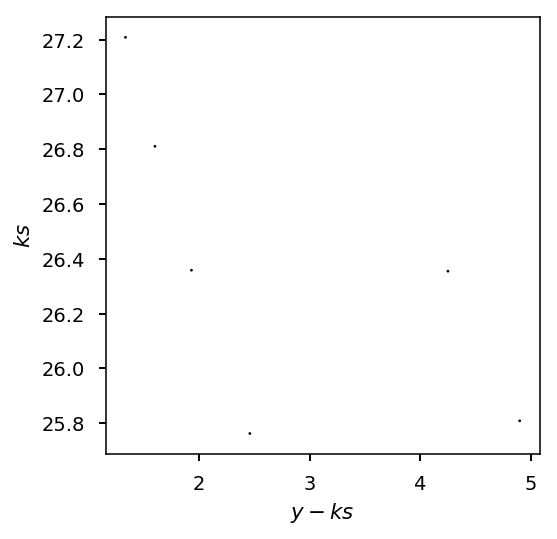

In [422]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(yMags[:,0] - ksMags[:,0],
            ksMags[:,0],
            edgecolors='None', s=2, c='k')
#plt.xlim(-0.5, 3)
#plt.ylim(25, 14)
plt.xlabel('$y-ks$')
plt.ylabel('$ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [423]:
yMags[:,0] 

array([        nan, 27.34614337,         nan,         nan, 28.2232311 ,
       28.41532979,         nan, 28.29207934,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      